PARTIAL CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in partial df: 1051
Rows that have all features = NaN: 21
TRAIN rows: 924
VAL   rows: 106
TEST  rows: 21
Current device: cuda

=== Training & Predicting with ARIMA, plus Additional Diagrams ===
[ARIMA] ARIMA baseline model created.


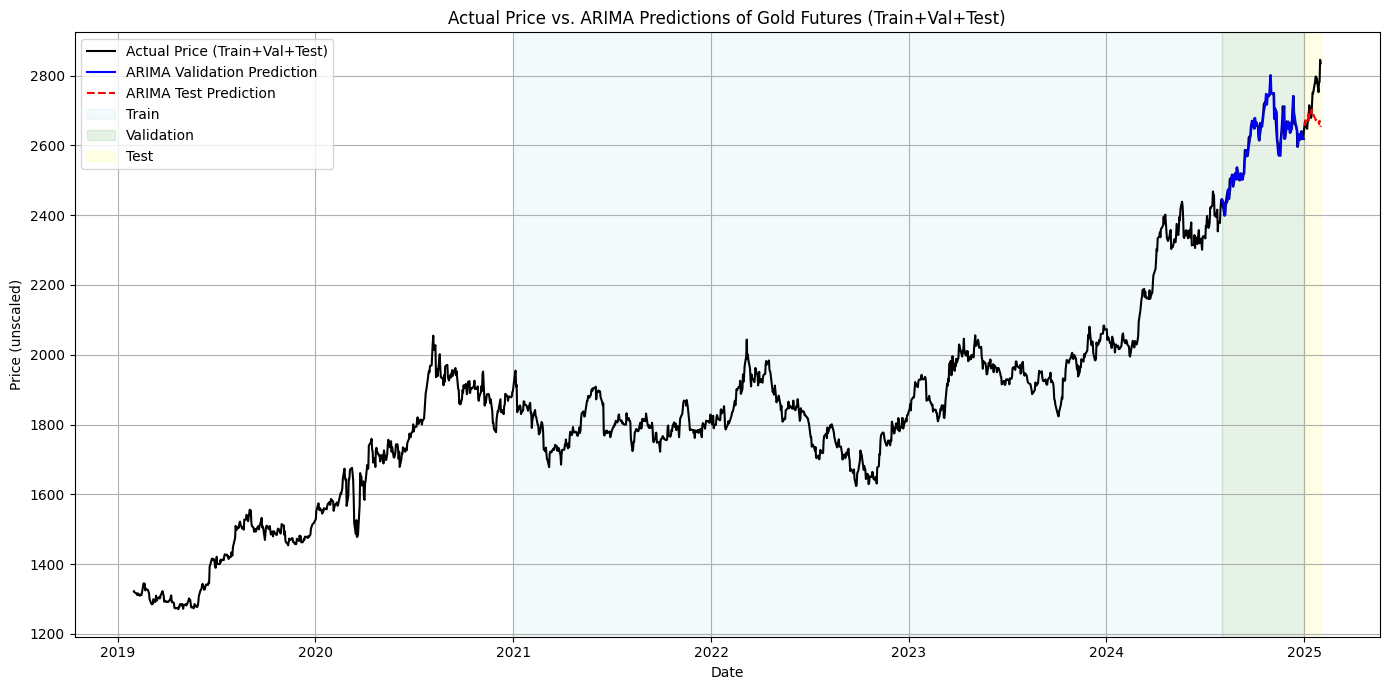

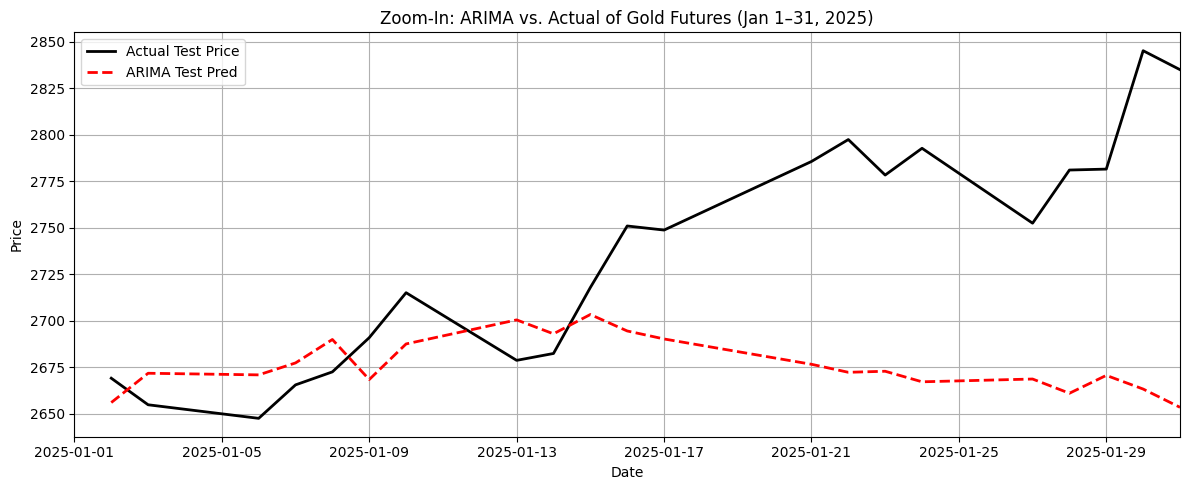

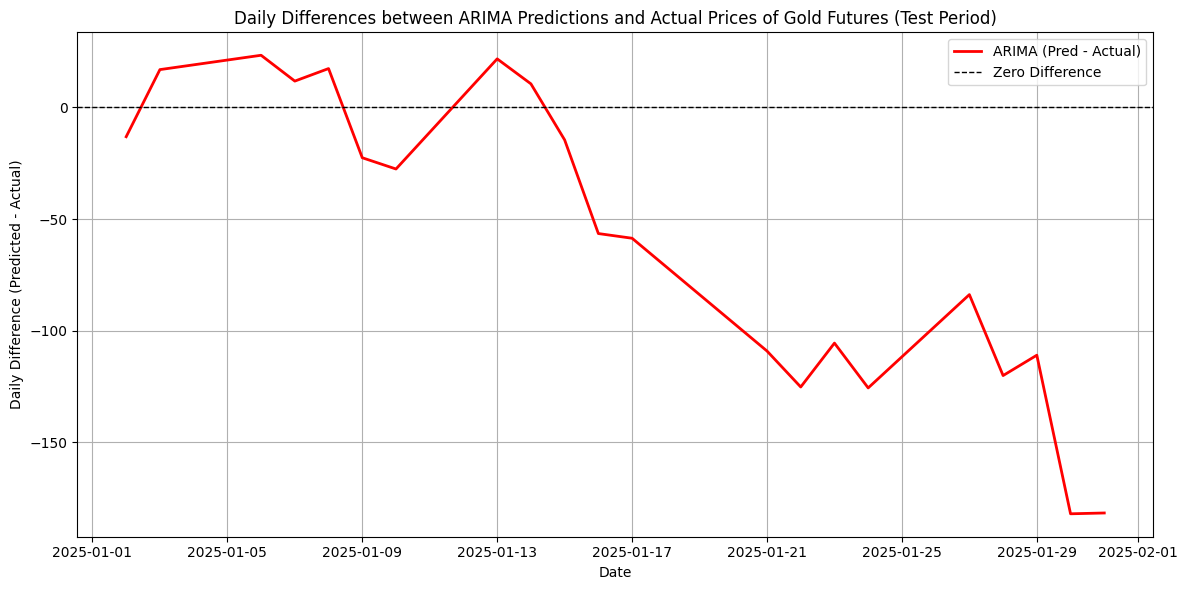

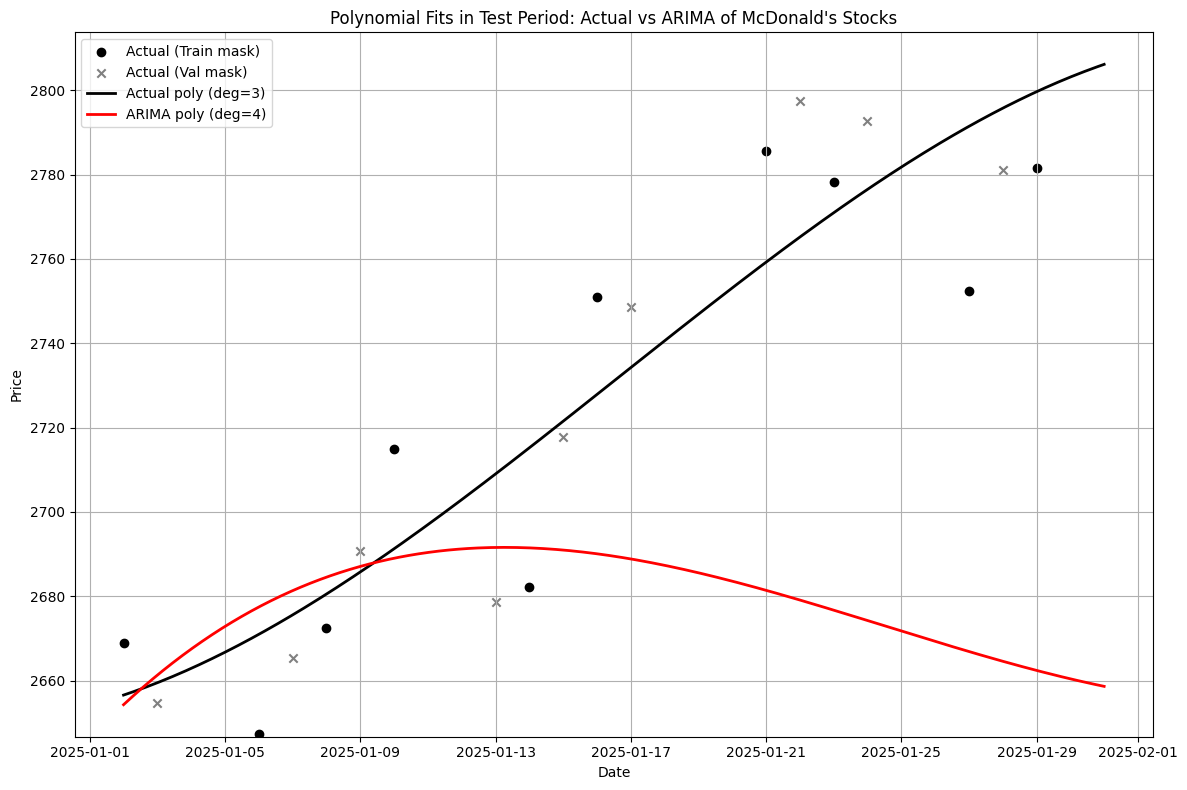

Actual: Best polynomial degree=3, Val MSE=458.5520
   y = -0.00579*x^3+349*x^2-7.02e+06*x+4.7e+10
ARIMA: Best polynomial degree=4, Val MSE=82.9130
   y = 1.62e-07*x^4-0.00653*x^3+0.0384*x^2+2.64e+06*x-2.66e+10


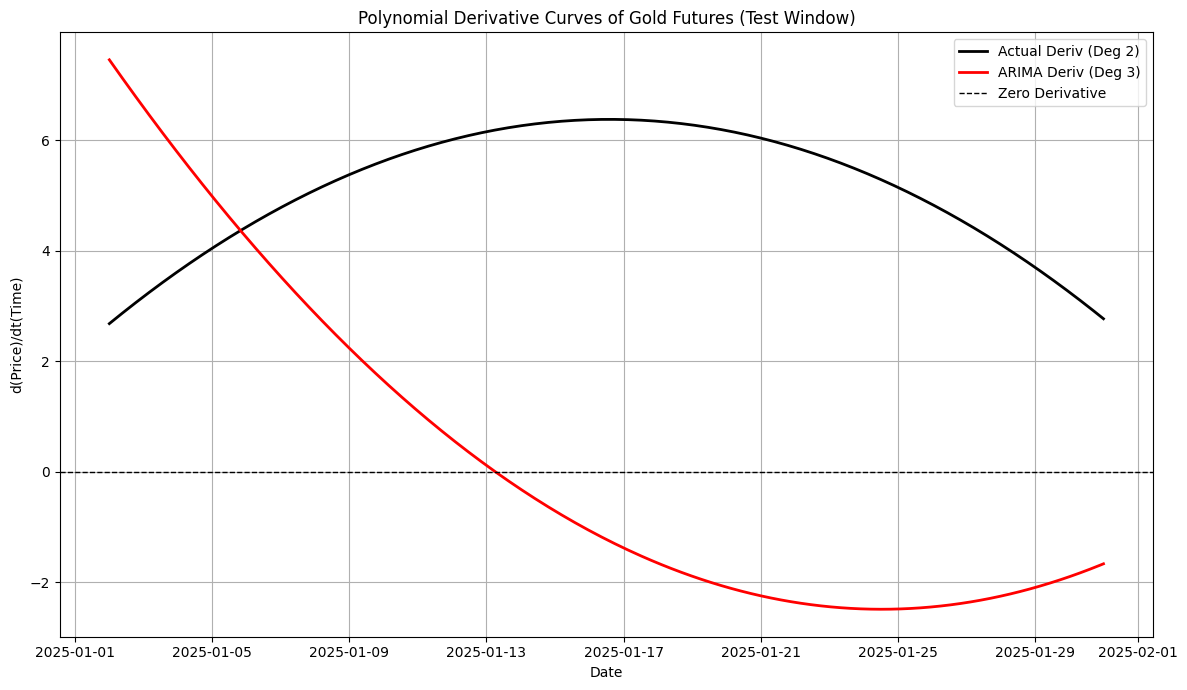


=== Polynomial Derivative Expressions ===
[Actual] (Deg 3) -> derivative: -0.0174*x^2+698*x-7.02e+06
[ARIMA] (Deg 4) -> derivative: 6.5e-07*x^3-0.0196*x^2+0.0768*x+2.64e+06

All tasks done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib
from statsmodels.tsa.arima.model import ARIMA
import torch.backends.cudnn as cudnn

###############################################################################
# 0. Suppress all warnings
###############################################################################
warnings.filterwarnings("ignore")

# Let CuDNN pick the fastest algorithm for your hardware
cudnn.benchmark = True

###############################################################################
# 1. Set random seeds
###############################################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################################
# Global hyperparameters
###############################################################################
WINDOW_SIZE = 35
features = ["Price", "Open", "High", "Low"]

# (A) For training: partial CSV
csv_file_partial = "Gold Futures Historical Data.csv"

# (B) For final plotting + actual test data: complete CSV
csv_file_complete = "Gold Futures Historical Data_Complete.csv"

###############################################################################
# 2. Load & Clean the partial CSV (used for train/val/test)
###############################################################################
df = pd.read_csv(csv_file_partial)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("PARTIAL CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in partial df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

###############################################################################
# 3. Date cutoffs: TRAIN, VAL, TEST
###############################################################################
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

###############################################################################
# 5. Create Training Sequences (for pipeline consistency)
###############################################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)
X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4
)

###############################################################################
# 6. ARIMA Baseline Model Definition
###############################################################################
class ARIMAModel(nn.Module):
    def __init__(self, order=(1,0,0), epsilon=1e-4):
        """
        ARIMA baseline model (univariate per feature).
        order: ARIMA order, e.g., (1,0,0) is AR(1).
        epsilon: threshold below which std is near-constant => fallback last value.
        """
        super().__init__()
        self.order = order
        self.epsilon = epsilon
        
    def forward(self, x):
        # x: shape (batch, window, features)
        batch_predictions = []
        for sample in x:
            sample_pred = []
            for feature_idx in range(sample.shape[1]):
                series = sample[:, feature_idx].detach().cpu().numpy()
                if np.std(series) < self.epsilon:
                    forecast = series[-1]
                else:
                    try:
                        model = ARIMA(series, order=self.order)
                        model_fit = model.fit(disp=0)
                        forecast = model_fit.forecast(steps=1)[0]
                    except:
                        forecast = series[-1]
                sample_pred.append(forecast)
            batch_predictions.append(sample_pred)

        return torch.tensor(batch_predictions).float().to(x.device)

def train_model_arima():
    model = ARIMAModel(order=(1,0,0)).to(device)
    print("[ARIMA] ARIMA baseline model created.")
    return model

###############################################################################
# 7. Validation Predictions (non-iterative)
###############################################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    scl_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:,0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:,1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:,2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:,3]
    return pred_df

###############################################################################
# 8. Iterative Walk-Forward Test Predictions
###############################################################################
def iterative_walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE, noise_std=0.01):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    test_idx = df_work.index[df_work["Date"] >= test_start]
    if len(test_idx) == 0:
        raise ValueError("No test data available after test_start.")
    first_test_idx = test_idx[0]

    current_window = df_work.iloc[first_test_idx - window:first_test_idx][features].values
    test_dates = np.sort(df_work.loc[df_work["Date"] >= test_start, "Date"].unique())

    preds = []
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]

            # Add random noise
            noise = np.random.normal(scale=noise_std, size=pred_scaled.shape)
            pred_scaled_noisy = pred_scaled + noise

            preds.append((d, *pred_scaled_noisy))
            current_window = np.vstack((current_window[1:], pred_scaled_noisy))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    scl_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:,0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:,1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:,2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:,3]
    return pred_df

###############################################################################
# 9A. Plot Full Timeline
###############################################################################
def evaluate_and_plot(val_pred_df, test_pred_df, complete_csv=csv_file_complete):
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    df_complete.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(14,7))
    # Entire actual line
    plt.plot(df_complete["Date"], df_complete["Price"], color="black", label="Actual Price (Train+Val+Test)")

    # ARIMA val
    if val_pred_df is not None and not val_pred_df.empty:
        plt.plot(val_pred_df["Date"], val_pred_df["Pred_Price_unscaled"],
                 color="blue", linestyle="-", label="ARIMA Validation Prediction")

    # ARIMA test
    if test_pred_df is not None and not test_pred_df.empty:
        plt.plot(test_pred_df["Date"], test_pred_df["Pred_Price_unscaled"],
                 color="red", linestyle="--", label="ARIMA Test Prediction")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, df_complete["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Actual Price vs. ARIMA Predictions of Gold Futures (Train+Val+Test)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 9B. Zoom on Jan 1–31, 2025
###############################################################################
def plot_test_period_zoom(test_pred_df, complete_csv=csv_file_complete):
    start_zoom = pd.to_datetime("2025-01-01")
    end_zoom   = pd.to_datetime("2025-01-31")

    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    df_test_actual = df_complete[
        (df_complete["Date"] >= start_zoom) & (df_complete["Date"] <= end_zoom)
    ].copy()

    if test_pred_df is not None and not test_pred_df.empty:
        test_pred_df_zoom = test_pred_df[
            (test_pred_df["Date"] >= start_zoom) &
            (test_pred_df["Date"] <= end_zoom)
        ].copy()
    else:
        test_pred_df_zoom = pd.DataFrame()

    plt.figure(figsize=(12,5))
    if not df_test_actual.empty:
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color="black", linewidth=2, label="Actual Test Price")

    if not test_pred_df_zoom.empty:
        plt.plot(test_pred_df_zoom["Date"], test_pred_df_zoom["Pred_Price_unscaled"],
                 color="red", linestyle="--", linewidth=2, label="ARIMA Test Pred")

    plt.xlim([start_zoom, end_zoom])
    plt.title("Zoom-In: ARIMA vs. Actual of Gold Futures (Jan 1–31, 2025)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 10. Additional Plots
###############################################################################
def plot_daily_difference(test_pred_df, complete_csv=csv_file_complete):
    """
    Plots the daily difference (Predicted - Actual) for the test period.
    """
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()
    df_test_actual = df_test_actual[["Date","Price"]].dropna()

    df_merge = pd.merge(test_pred_df, df_test_actual, on="Date", how="inner")
    df_merge.sort_values("Date", inplace=True)
    df_merge["Difference"] = df_merge["Pred_Price_unscaled"] - df_merge["Price"]

    plt.figure(figsize=(12,6))
    plt.plot(df_merge["Date"], df_merge["Difference"], color="red", linewidth=2, label="ARIMA (Pred - Actual)")
    plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Difference")
    plt.xlabel("Date")
    plt.ylabel("Daily Difference (Predicted - Actual)")
    plt.title("Daily Differences between ARIMA Predictions and Actual Prices of Gold Futures (Test Period)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def format_polynomial(coeffs):
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        sign = "+" if c >= 0 else ""
        if power > 1:
            terms.append(f"{sign}{c:.3g}*x^{power}")
        elif power == 1:
            terms.append(f"{sign}{c:.3g}*x")
        else:
            terms.append(f"{sign}{c:.3g}")
    expr = "".join(terms).replace("+-","-")
    return expr.strip("+")

def derivative_expression(coeffs):
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

def polynomial_fitting_and_derivatives(test_pred_df, complete_csv=csv_file_complete):
    df_full = pd.read_csv(complete_csv)
    df_full.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_full["Date"] = pd.to_datetime(df_full["Date"], errors="coerce")
    df_full.sort_values("Date", inplace=True)
    for col in features:
        if col not in df_full.columns:
            df_full[col] = np.nan
        else:
            df_full[col] = df_full[col].astype(str).str.replace(",", "", regex=True)
            df_full[col] = pd.to_numeric(df_full[col], errors="coerce")

    df_test_actual = df_full[df_full["Date"] >= test_cutoff].copy()
    df_test_actual = df_test_actual[["Date","Price"]].rename(columns={"Price":"Actual"})
    df_test_actual.dropna(subset=["Actual"], inplace=True)

    if test_pred_df is not None and not test_pred_df.empty:
        test_ren = test_pred_df[["Date","Pred_Price_unscaled"]].rename(columns={"Pred_Price_unscaled":"ARIMA"})
        df_poly = pd.merge(df_test_actual, test_ren, on="Date", how="inner")
    else:
        df_poly = df_test_actual.copy()
        df_poly["ARIMA"] = np.nan

    df_poly.dropna(axis=0, how="any", inplace=True)
    df_poly.reset_index(drop=True, inplace=True)

    df_poly["mdates_num"] = mdates.date2num(df_poly["Date"])

    n_points = len(df_poly)
    indices = np.arange(n_points)
    train_mask = (indices % 2 == 0)
    val_mask   = ~train_mask

    columns_to_fit = ["Actual","ARIMA"]
    best_poly = {}
    deg_candidates = range(1, 70)

    def val_mse(coeffs, x_val, y_val):
        y_val_pred = np.polyval(coeffs, x_val)
        return mean_squared_error(y_val, y_val_pred)

    for col in columns_to_fit:
        x_train = df_poly.loc[train_mask,"mdates_num"].values
        y_train = df_poly.loc[train_mask,col].values
        x_val   = df_poly.loc[val_mask,"mdates_num"].values
        y_val   = df_poly.loc[val_mask,col].values

        best_info = {"degree":None, "coeffs":None, "val_mse":float("inf")}
        for d in deg_candidates:
            coeffs = np.polyfit(x_train, y_train, d)
            this_mse = val_mse(coeffs, x_val, y_val)
            if this_mse < best_info["val_mse"]:
                best_info["degree"] = d
                best_info["coeffs"] = coeffs
                best_info["val_mse"] = this_mse
        best_poly[col] = best_info

    # Plot polynomial fits
    plt.figure(figsize=(12,8))
    # Plot actual data points for "Actual"
    plt.scatter(df_poly.loc[train_mask,"Date"], df_poly.loc[train_mask,"Actual"],
                color="black", marker="o", label="Actual (Train mask)")
    plt.scatter(df_poly.loc[val_mask,"Date"], df_poly.loc[val_mask,"Actual"],
                color="gray", marker="x", label="Actual (Val mask)")

    x_dense = np.linspace(df_poly["mdates_num"].min(), df_poly["mdates_num"].max(), 300)
    x_dates = [mdates.num2date(xx) for xx in x_dense]
    colors_map = {"Actual":"black", "ARIMA":"red"}

    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        coeffs = best_poly[col]["coeffs"]
        y_dense = np.polyval(coeffs, x_dense)
        plt.plot(x_dates, y_dense, color=colors_map.get(col,"gray"),
                 linewidth=2, label=f"{col} poly (deg={deg})")

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Polynomial Fits in Test Period: Actual vs ARIMA of McDonald's Stocks")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print best polynomial expressions
    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        msev = best_poly[col]["val_mse"]
        expr = format_polynomial(best_poly[col]["coeffs"])
        print(f"{col}: Best polynomial degree={deg}, Val MSE={msev:.4f}")
        print(f"   y = {expr}")

    # Plot derivative curves
    plt.figure(figsize=(12,7))
    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        coeffs = best_poly[col]["coeffs"]
        d_coeffs = np.polyder(coeffs)
        y_deriv = np.polyval(d_coeffs, x_dense)
        plt.plot(x_dates, y_deriv, color=colors_map.get(col,"gray"),
                 linewidth=2, label=f"{col} Deriv (Deg {deg -1})")

    plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Derivative")
    plt.xlabel("Date")
    plt.ylabel("d(Price)/dt(Time)")
    plt.title("Polynomial Derivative Curves of Gold Futures (Test Window)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Finally, print derivative expressions
    print("\n=== Polynomial Derivative Expressions ===")
    for col in columns_to_fit:
        d_expr = derivative_expression(best_poly[col]["coeffs"])
        print(f"[{col}] (Deg {best_poly[col]['degree']}) -> derivative: {d_expr}")

###############################################################################
# 11. MAIN
###############################################################################
if __name__ == "__main__":
    print("\n=== Training & Predicting with ARIMA, plus Additional Diagrams ===")
    
    # (A) Create ARIMA-based model
    model = train_model_arima()
    
    # (B) Validation predictions (half-blind)
    val_pred_df = half_blind_validation_preds_df(
        model,
        df_scaled,
        val_start=train_cutoff,
        val_end=val_cutoff,
        window=WINDOW_SIZE
    )
    
    # (C) Test predictions (iterative + noise)
    test_pred_df = iterative_walk_forward_test(
        model,
        df_all_scaled=df_scaled,
        test_start=test_cutoff,
        window=WINDOW_SIZE,
        noise_std=0.01
    )
    
    # (D) Evaluate + Plot entire timeline
    evaluate_and_plot(val_pred_df, test_pred_df, complete_csv=csv_file_complete)
    
    # (E) Zoom in on Jan 1–31, 2025
    plot_test_period_zoom(test_pred_df, complete_csv=csv_file_complete)

    # (F) Plot daily differences
    if test_pred_df is not None and not test_pred_df.empty:
        plot_daily_difference(test_pred_df, complete_csv=csv_file_complete)

    # (G) Polynomial Fitting + Derivative Plots
    polynomial_fitting_and_derivatives(test_pred_df, complete_csv=csv_file_complete)

    print("\nAll tasks done.")



=== Polynomial Fit Results ===
Actual: degree=3, val_MSE=458.5520
   y = -0.00579*x^3+349*x^2-7.02e+06*x+4.7e+10
ARIMA: degree=4, val_MSE=82.9130
   y = 1.62e-07*x^4-0.00653*x^3+0.0384*x^2+2.64e+06*x-2.66e+10


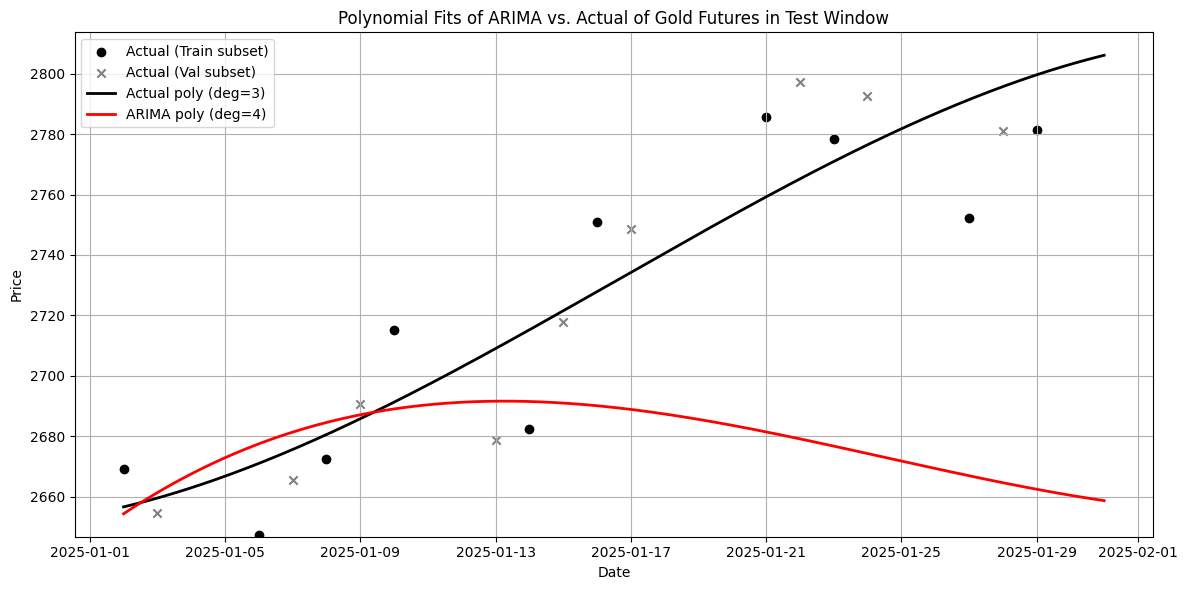


===== Naive Conservative (ARIMA Gradient) Trade Log =====
Long  | 2025-01-02 -> 2025-01-13 (8 days) | Entry=2669.00, Exit=2678.60 (Diff=9.60) | Return=0.36% | EndCap=100.36
Short | 2025-01-14 -> 2025-01-31 (13 days) | Entry=2682.30, Exit=2835.00 (Diff=152.70) | Return=-5.39% | EndCap=94.95

=== Final Results: Naive Conservative (ARIMA Gradient) ===
Final Capital = 94.95, PnL=-5.05, Return=-5.05%


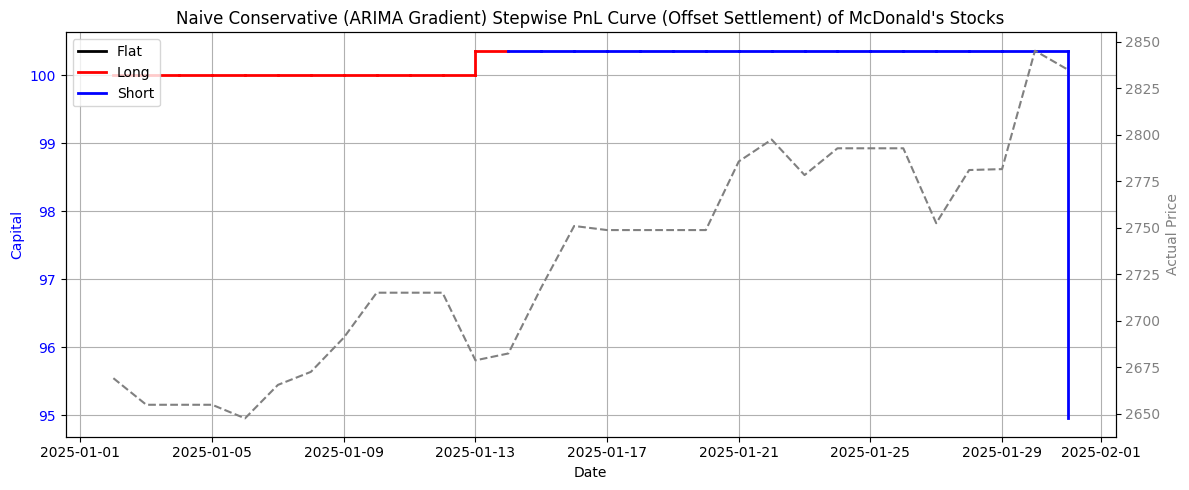


===== Naive Optimistic (ARIMA Gradient) Trade Log =====
Long  | 2025-01-02 -> 2025-01-13 (8 days) | Entry=2669.00, Exit=2678.60 (Diff=9.60) | Return=0.36% | EndCap=100.36
Short | 2025-01-14 -> 2025-01-31 (13 days) | Entry=2682.30, Exit=2835.00 (Diff=152.70) | Return=-5.39% | EndCap=94.95

=== Final Results: Naive Optimistic (ARIMA Gradient) ===
Final Capital = 94.95, PnL=-5.05, Return=-5.05%


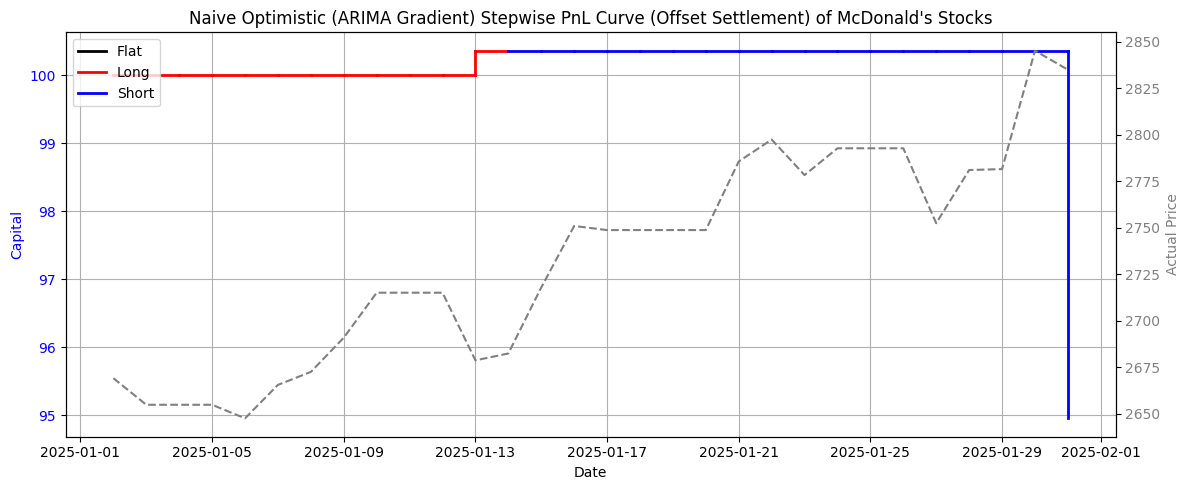

In [2]:
###############################################################################
# A. Convert ARIMA Test Predictions -> DataFrame for Polynomial Fitting
###############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# 1) We'll assume you already have `test_pred_df` with columns:
#    ["Date", "Pred_Price_unscaled", "Pred_Open_unscaled", "Pred_High_unscaled", "Pred_Low_unscaled"]
#    from the ARIMA walk-forward predictions.
#
# 2) We also need the actual test data. In your code, you have `csv_file_complete` and a cutoff `test_cutoff`.

# Load the complete CSV for the actual price series:
df_full = pd.read_csv(csv_file_complete)
df_full.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_full["Date"] = pd.to_datetime(df_full["Date"], errors="coerce")
df_full.sort_values("Date", inplace=True)
for col in features:
    if col not in df_full.columns:
        df_full[col] = np.nan
    else:
        df_full[col] = df_full[col].astype(str).str.replace(",", "", regex=True)
        df_full[col] = pd.to_numeric(df_full[col], errors="coerce")

# Filter to the test window: (dates >= test_cutoff)
df_test_actual = df_full[df_full["Date"] >= test_cutoff].copy()
df_test_actual = df_test_actual[["Date", "Price"]].rename(columns={"Price": "Actual"})
df_test_actual.dropna(subset=["Actual"], inplace=True)

# Merge actual test with ARIMA predictions on "Date"
df_test_poly = pd.merge(
    df_test_actual,
    test_pred_df[["Date", "Pred_Price_unscaled"]],
    on="Date",
    how="inner"
).rename(columns={"Pred_Price_unscaled": "ARIMA"})

# Clean up any missing rows
df_test_poly.dropna(axis=0, how="any", inplace=True)
df_test_poly.reset_index(drop=True, inplace=True)

# Convert to numeric day values for polynomial fitting
df_test_poly["mdates_num"] = mdates.date2num(df_test_poly["Date"])

###############################################################################
# B. Polynomial Fit for ARIMA & Actual
###############################################################################
def format_polynomial(coeffs):
    """
    Convert polynomial coefficients into a readable expression.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        sign = "+" if c >= 0 else ""
        if power > 1:
            terms.append(f"{sign}{c:.3g}*x^{power}")
        elif power == 1:
            terms.append(f"{sign}{c:.3g}*x")
        else:
            terms.append(f"{sign}{c:.3g}")
    expr = "".join(terms).replace("+-", "-")
    return expr.strip("+")

def derivative_expression(coeffs):
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

# We’ll fit polynomials for "ARIMA" and "Actual" columns:
columns_to_fit = ["Actual", "ARIMA"]
deg_candidates = range(1, 70)  # polynomial degrees to try

# Split day indices into (train_mask, val_mask) for polynomial hyperparam selection
n_pts = len(df_test_poly)
indices = np.arange(n_pts)
train_mask = (indices % 2 == 0)
val_mask   = ~train_mask

best_poly_info = {}
def val_mse(coeffs, x_val, y_val):
    y_pred = np.polyval(coeffs, x_val)
    return mean_squared_error(y_val, y_pred)

for col in columns_to_fit:
    x_train = df_test_poly.loc[train_mask, "mdates_num"].values
    y_train = df_test_poly.loc[train_mask, col].values
    x_val   = df_test_poly.loc[val_mask, "mdates_num"].values
    y_val   = df_test_poly.loc[val_mask, col].values

    best_info = {"degree": None, "coeffs": None, "val_mse": float("inf")}
    for d in deg_candidates:
        coeffs = np.polyfit(x_train, y_train, d)
        mse = val_mse(coeffs, x_val, y_val)
        if mse < best_info["val_mse"]:
            best_info["degree"] = d
            best_info["coeffs"] = coeffs
            best_info["val_mse"] = mse
    best_poly_info[col] = best_info

# 1) Print each polynomial’s best degree & expression
print("\n=== Polynomial Fit Results ===")
for col in columns_to_fit:
    deg = best_poly_info[col]["degree"]
    mse = best_poly_info[col]["val_mse"]
    expr = format_polynomial(best_poly_info[col]["coeffs"])
    print(f"{col}: degree={deg}, val_MSE={mse:.4f}")
    print(f"   y = {expr}")

# 2) Plot polynomial fits
plt.figure(figsize=(12,6))
plt.scatter(df_test_poly.loc[train_mask,"Date"], df_test_poly.loc[train_mask,"Actual"],
            color="black", marker="o", label="Actual (Train subset)")
plt.scatter(df_test_poly.loc[val_mask,"Date"], df_test_poly.loc[val_mask,"Actual"],
            color="gray",  marker="x", label="Actual (Val subset)")

x_dense = np.linspace(df_test_poly["mdates_num"].min(), df_test_poly["mdates_num"].max(), 300)
x_dense_dates = [mdates.num2date(xx) for xx in x_dense]

color_map = {"Actual":"black", "ARIMA":"red"}
for col in columns_to_fit:
    coeffs = best_poly_info[col]["coeffs"]
    y_dense = np.polyval(coeffs, x_dense)
    plt.plot(x_dense_dates, y_dense,
             color=color_map.get(col, "blue"), linewidth=2,
             label=f"{col} poly (deg={best_poly_info[col]['degree']})")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Polynomial Fits of ARIMA vs. Actual of Gold Futures in Test Window")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###############################################################################
# C. Derivatives & Basic "Naive" Strategies
###############################################################################
# With one model, "Naive Conservative" and "Naive Optimistic" produce same signals.
# We'll still show them separately for clarity.

# 1) Compute ARIMA's derivative at each date
arima_d_coeffs = np.polyder(best_poly_info["ARIMA"]["coeffs"])
df_test_poly["ARIMA_Gradient"] = np.polyval(arima_d_coeffs, df_test_poly["mdates_num"])

# 2) Naive Conservative: 
#    - Long if ARIMA_Gradient > 0
#    - Short if ARIMA_Gradient < 0
#    - Flat if ARIMA_Gradient == 0
signals_conservative = np.zeros(len(df_test_poly), dtype=int)
for i in range(len(df_test_poly)):
    grad = df_test_poly.loc[i, "ARIMA_Gradient"]
    if grad > 0:
        signals_conservative[i] = 1
    elif grad < 0:
        signals_conservative[i] = -1
    else:
        signals_conservative[i] = 0

# 3) Naive Optimistic (same for single model)
signals_optimistic = signals_conservative.copy()

###############################################################################
# D. Piecewise Trading Simulation
###############################################################################
def get_segments(df_signal, signal_col="Signal"):
    """
    Identify contiguous segments with the same signal.
    Returns a list of (start_index, end_index, signal_value).
    """
    segments = []
    start_idx = 0
    curr_sig = df_signal.loc[0, signal_col]
    for idx in range(1, len(df_signal)):
        if df_signal.loc[idx, signal_col] != curr_sig:
            segments.append((start_idx, idx - 1, curr_sig))
            start_idx = idx
            curr_sig = df_signal.loc[idx, signal_col]
    segments.append((start_idx, len(df_signal)-1, curr_sig))
    return segments

def piecewise_trading_offset(df_signal):
    """
    Each segment with same signal for >=2 days => realize PnL at segment end.
    1-day segments => no position.
    Initial capital = 100.
    """
    segs = get_segments(df_signal, "Signal")
    capital = 100.0
    cap_arr = np.zeros(len(df_signal))
    trade_log = []
    
    for (start, end, sig) in segs:
        seg_days = end - start + 1
        start_date = df_signal.loc[start, "Date"]
        end_date   = df_signal.loc[end, "Date"]
        
        # Fill capital across this segment
        for i in range(start, end+1):
            cap_arr[i] = capital
        
        if seg_days < 2:
            # 1-day => ignore
            trade_log.append({
                "Signal": "Flat(ignored)",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": df_signal.loc[start, "Actual"],
                "ExitPrice": df_signal.loc[end, "Actual"],
                "AbsDiff": 0.0,
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
            continue
        
        # Otherwise, realize PnL at end
        entry_price = df_signal.loc[start, "Actual"]
        exit_price  = df_signal.loc[end, "Actual"]
        if sig == 1:
            # Long
            final_cap = capital * (exit_price / entry_price)
            seg_ret   = (final_cap / capital) - 1.0
            cap_arr[end] = final_cap
            capital = final_cap
            trade_log.append({
                "Signal": "Long",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": seg_ret*100,
                "EndCapital": final_cap
            })
        elif sig == -1:
            # Short
            final_cap = capital * (entry_price / exit_price)
            seg_ret   = (final_cap / capital) - 1.0
            cap_arr[end] = final_cap
            capital = final_cap
            trade_log.append({
                "Signal": "Short",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": seg_ret*100,
                "EndCapital": final_cap
            })
        else:
            # Flat
            trade_log.append({
                "Signal": "Flat",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
    
    # Forward-fill capital after last segment
    last_cap = capital
    for i in range(len(df_signal)):
        if cap_arr[i] == 0.0:
            cap_arr[i] = last_cap
        else:
            last_cap = cap_arr[i]
    
    df_signal["Capital"] = cap_arr
    df_signal["Cumulative_PnL"] = df_signal["Capital"] - 100.0
    df_signal["Cumulative_Return"] = (df_signal["Cumulative_PnL"]/100.0)*100.0
    return df_signal, trade_log

def reindex_daily(df_signal):
    """
    Reindex to daily frequency, forward-fill columns.
    """
    df_signal = df_signal.copy()
    df_signal.set_index("Date", inplace=True)
    all_days = pd.date_range(start=df_signal.index.min(), end=df_signal.index.max(), freq="D")
    df_signal = df_signal.reindex(all_days)
    df_signal["Actual"].ffill(inplace=True)
    df_signal["Capital"].ffill(inplace=True)
    df_signal["Cumulative_PnL"].ffill(inplace=True)
    df_signal["Cumulative_Return"].ffill(inplace=True)
    df_signal["Signal"].ffill(inplace=True)
    df_signal.reset_index(inplace=True)
    df_signal.rename(columns={"index":"Date"}, inplace=True)
    return df_signal

###############################################################################
# E. Run Naive Conservative vs. Naive Optimistic
###############################################################################
df_con = df_test_poly.copy()
df_con["Signal"] = signals_conservative
df_con_sim, trade_log_con = piecewise_trading_offset(df_con)
df_con_sim = reindex_daily(df_con_sim)

df_opt = df_test_poly.copy()
df_opt["Signal"] = signals_optimistic
df_opt_sim, trade_log_opt = piecewise_trading_offset(df_opt)
df_opt_sim = reindex_daily(df_opt_sim)

###############################################################################
# F. Stepwise Plotting
###############################################################################
def plot_pnl_curve(df_signal, trade_log, title=""):
    print(f"\n===== {title} Trade Log =====")
    for t in trade_log:
        print(
            f"{t['Signal']:5s} | {t['StartDate'].date()} -> {t['EndDate'].date()} "
            f"({t['Days']} days) | "
            f"Entry={t['EntryPrice']:.2f}, Exit={t['ExitPrice']:.2f} "
            f"(Diff={t['AbsDiff']:.2f}) | "
            f"Return={t['SegmentReturn(%)']:.2f}% | "
            f"EndCap={t['EndCapital']:.2f}"
        )
    final_cap = df_signal["Capital"].iloc[-1]
    final_pnl = df_signal["Cumulative_PnL"].iloc[-1]
    final_ret = df_signal["Cumulative_Return"].iloc[-1]
    print(f"\n=== Final Results: {title} ===")
    print(f"Final Capital = {final_cap:.2f}, PnL={final_pnl:.2f}, Return={final_ret:.2f}%")

    fig, ax1 = plt.subplots(figsize=(12,5))
    color_map = {0:"black", 1:"red", -1:"blue"}
    n_rows = len(df_signal)

    for i in range(1, n_rows):
        sig_prev = int(df_signal.loc[i-1, "Signal"])
        # Horizontal
        x_h = [df_signal.loc[i-1,"Date"], df_signal.loc[i,"Date"]]
        y_h = [df_signal.loc[i-1,"Capital"], df_signal.loc[i-1,"Capital"]]
        ax1.plot(x_h, y_h, color=color_map[sig_prev], linewidth=2)
        # Vertical
        x_v = [df_signal.loc[i,"Date"], df_signal.loc[i,"Date"]]
        y_v = [df_signal.loc[i-1,"Capital"], df_signal.loc[i,"Capital"]]
        ax1.plot(x_v, y_v, color=color_map[sig_prev], linewidth=2)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Capital", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(df_signal["Date"], df_signal["Actual"], color="gray", linestyle="--", linewidth=1.5)
    ax2.set_ylabel("Actual Price", color="gray")
    ax2.tick_params(axis="y", labelcolor="gray")

    legend_elems = [
        Line2D([0],[0], color='black', lw=2, label='Flat'),
        Line2D([0],[0], color='red',   lw=2, label='Long'),
        Line2D([0],[0], color='blue',  lw=2, label='Short')
    ]
    ax1.legend(handles=legend_elems, loc="upper left")
    ax1.set_title(f"{title} Stepwise PnL Curve (Offset Settlement) of McDonald's Stocks")
    plt.tight_layout()
    plt.show()

###############################################################################
# G. Final Plots & Logs
###############################################################################
plot_pnl_curve(df_con_sim, trade_log_con, title="Naive Conservative (ARIMA Gradient)")
plot_pnl_curve(df_opt_sim, trade_log_opt, title="Naive Optimistic (ARIMA Gradient)")
